# ER and Medicine Spatial Research
#### June.2025


In [10]:
packages <- c("readr", "dplyr", "psych", "ggplot2", "forcats",
              "tidyverse", "spdep", "sf", "stringr")

invisible(lapply(packages, function(pkg) suppressMessages(library(pkg, character.only = TRUE))))

### 1. Prepare Data to Process

In [11]:
### Read and Prepare Data
# Create folder
if (!dir.exists("output")) {
  dir.create("output")
}

# Read and Clean Data_ER
Data_ER <- read_csv("../Data/ER_opioid_2016_2019_cleaned.csv", show_col_types = FALSE)

Data_ER_filted <- Data_ER%>%
  filter(County %in% toupper(c(
    "Lauderdale", "Limestone", "Madison", "Jackson", "Colbert", "Franklin",
    "Lawrence", "Morgan", "Marshall", "Dekalb", "Marion", "Winston",
    "Cullman", "Blount", "Etowah", "Cherokee", "Lamar", "Fayette",
    "Walker", "Jefferson", "St. Clair", "Pickens", "Tuscaloosa", "Shelby"
  ))
  )

Data_ER_filted <- Data_ER_filted %>%
  mutate(
    year = as.numeric(format(Date, "%Y")),
    month = as.numeric(format(Date, "%m")),
    year_month = paste(year,month),
    week = as.numeric(format(Date, "%U"))  # Week number of year (starting from 0)
  )

New names:
• `` -> `...1`


#### 1. Descriptive Statistic for ER Visits

In [12]:
# Summary of Total Visit by County
Data_County_summary_total <- Data_ER_filted %>%
  group_by(year, County) %>%
  summarise(
    mean = mean(Count, na.rm = TRUE),
    total = sum(Count),
    avg_percapita = mean(case_percapita),
    .groups = "drop"
  )%>%
  select(year, County, total) %>%
  pivot_wider(
    names_from = year,
    values_from = total,
    names_prefix = "Total_"
  )%>%
  mutate(
    Total = rowSums(select(., starts_with("Total_")), na.rm = TRUE)
  )


head(Data_County_summary_total)


County,Total_2016,Total_2017,Total_2018,Total_2019,Total
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BLOUNT,102,94,58,42,296
CHEROKEE,10,19,39,75,143
COLBERT,52,86,61,134,333
CULLMAN,53,67,59,52,231
ETOWAH,32,36,80,124,272
FAYETTE,25,20,18,11,74


In [13]:
# Summary of Per Capita Visit (per 1000000 people) by County
Data_County_summary_per <- Data_ER_filted %>%
  group_by(year, County) %>%
  summarise(
    mean = mean(Count, na.rm = TRUE),
    total = sum(Count),
    avg_percapita = round(1000000 * mean(case_percapita), 2),
      .groups = "drop"
  )%>%
  select(year, County, avg_percapita) %>%
  pivot_wider(
    names_from = year,
    values_from = avg_percapita,
    names_prefix = "Rate_"
  )%>%
  mutate(
    Avg_Rate = round(rowMeans(select(., starts_with("Rate_")), na.rm = TRUE), 2)
  )

head(Data_County_summary_per)

County,Rate_2016,Rate_2017,Rate_2018,Rate_2019,Avg_Rate
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BLOUNT,4.85,4.46,2.75,1.99,3.51
CHEROKEE,1.06,2.02,4.11,7.84,3.76
COLBERT,2.61,4.31,3.04,6.65,4.15
CULLMAN,1.76,2.22,1.94,1.70,1.91
ETOWAH,0.85,0.96,2.14,3.32,1.82
FAYETTE,4.12,3.33,3.00,1.85,3.08


In [15]:
# Calculate average population by County across four years
County_population_average <- Data_ER_filted %>%
  group_by(County) %>%
  summarise(
    pop_avg = mean(pop, na.rm = TRUE)
  )%>%
  select(County, pop_avg)

head(County_population_average)

County,pop_avg
<chr>,<dbl>
BLOUNT,57719.35
CHEROKEE,25945.63
COLBERT,54859.00
CULLMAN,83125.29
ETOWAH,102685.37
FAYETTE,16444.08


In [16]:
# merge all tables by County
Data_County_pop_sum <- merge(
  County_population_average,
  Data_County_summary_total, 
  by = "County"
)

Data_County_pop_sum_rate <- merge(
  Data_County_pop_sum,
  Data_County_summary_per, 
  by = "County"
)

Data_County_combined <- Data_County_pop_sum_rate%>%
  select(
    County,
    pop_avg,
    pop_avg,
    Total_2016, Rate_2016,
    Total_2017, Rate_2017,
    Total_2018, Rate_2018,
    Total_2019, Rate_2019,
    Total, Avg_Rate
  )

head(Data_County_combined)

# Save to CSV
write.csv(Data_County_combined, "../output/County_summary.csv", row.names = FALSE)

,County,pop_avg,Total_2016,Rate_2016,Total_2017,Rate_2017,Total_2018,Rate_2018,Total_2019,Rate_2019,Total,Avg_Rate
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,BLOUNT,57719.35,102,4.85,94,4.46,58,2.75,42,1.99,296,3.51
2,CHEROKEE,25945.63,10,1.06,19,2.02,39,4.11,75,7.84,143,3.76
3,COLBERT,54859.00,52,2.61,86,4.31,61,3.04,134,6.65,333,4.15
4,CULLMAN,83125.29,53,1.76,67,2.22,59,1.94,52,1.70,231,1.91
5,ETOWAH,102685.37,32,0.85,36,0.96,80,2.14,124,3.32,272,1.82
6,FAYETTE,16444.08,25,4.12,20,3.33,18,3.00,11,1.85,74,3.08


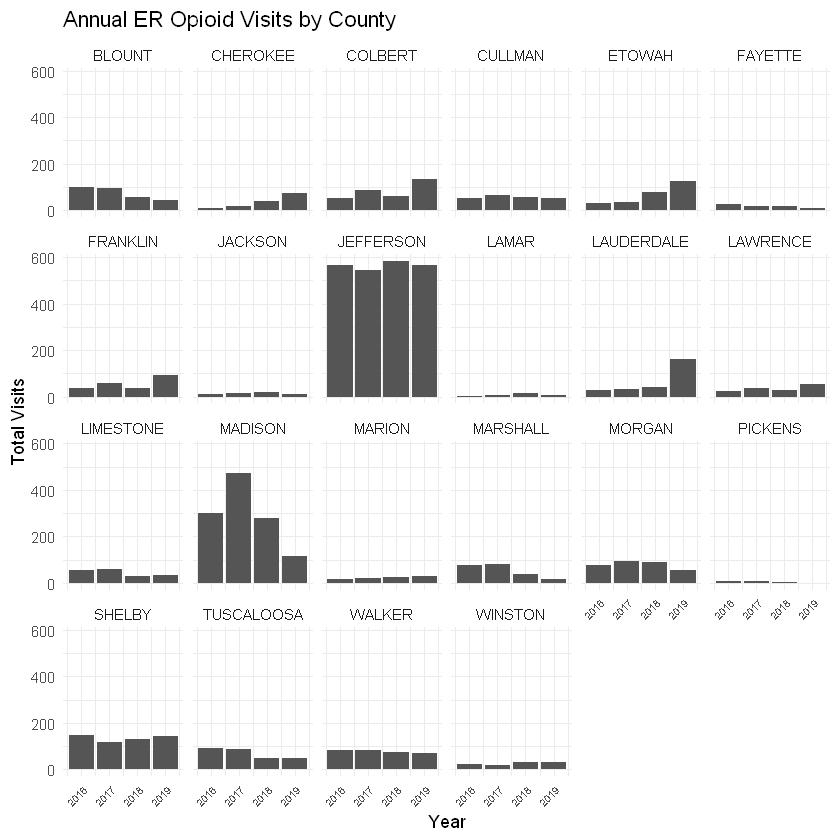

In [17]:
## Summary of County by Year
p <- Data_ER_filted %>%
  group_by(year, County) %>%
  summarise(total = sum(Count), .groups = "drop") %>%
  ggplot(aes(x = year, y = total, group = County)) +
  geom_col(fill = "#555555") +
  # geom_smooth(method = "lm", se = FALSE, color = "red", linewidth = 0.8) +  # Regression line
  facet_wrap(~ County, ncol = 6) + #, scales = "free_y"
  labs(
    title = "Annual ER Opioid Visits by County",
    x = "Year", y = "Total Visits"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 6))

# Display in notebook
print(p)

# Save the figure
ggsave("../output/1_summary_year.png", plot = p, width = 6.5, height = 4.5, dpi = 300)

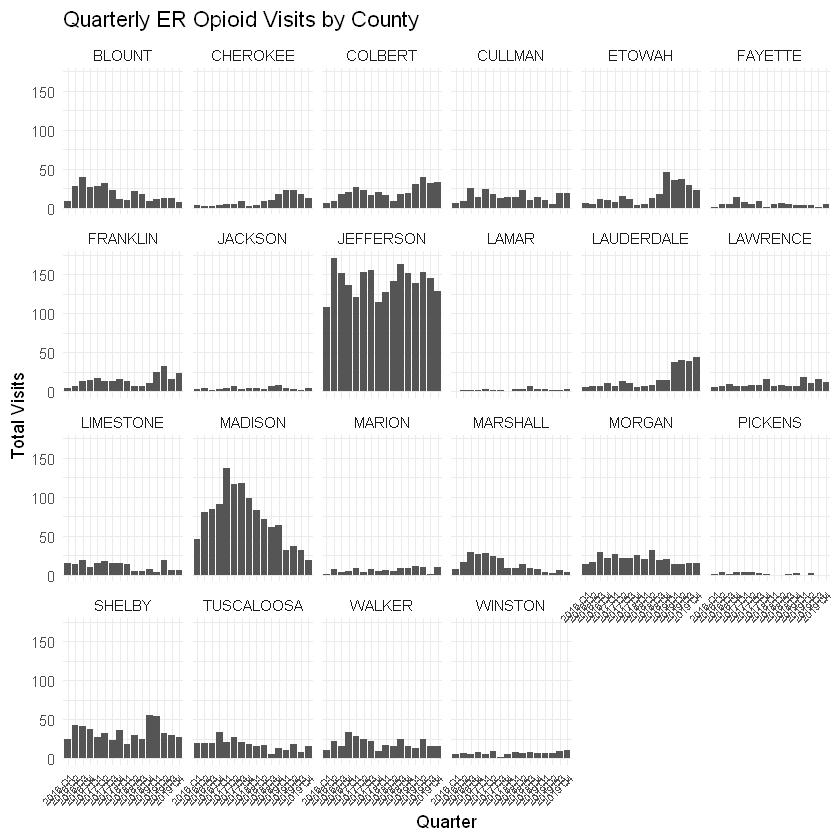

In [18]:
## Summary of County by [Quarterly]

# Create year_quarter variable
Data_ER_filted_quarter <- Data_ER_filted %>%
  mutate(
    date = ym(year_month),  # Convert to date
    year = year(date),
    quarter = quarter(date),
    year_quarter = paste0(year, " Q", quarter)
  )

# Group by year_quarter and County
p <- Data_ER_filted_quarter %>%
  group_by(year_quarter, County) %>%
  summarise(total = sum(Count), .groups = "drop") %>%
  mutate(year_quarter = factor(year_quarter, levels = unique(year_quarter))) %>%
  ggplot(aes(x = year_quarter, y = total, group = County)) +
  geom_col(fill = "#555555") +
  facet_wrap(~ County, ncol = 6) +
  labs(
    title = "Quarterly ER Opioid Visits by County",
    x = "Quarter", y = "Total Visits"
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 6)
  )

# Display plot
print(p)

# Save the figure
ggsave("../output/1_summary_quarter.png", plot = p, width = 8, height = 5.5, dpi = 300)

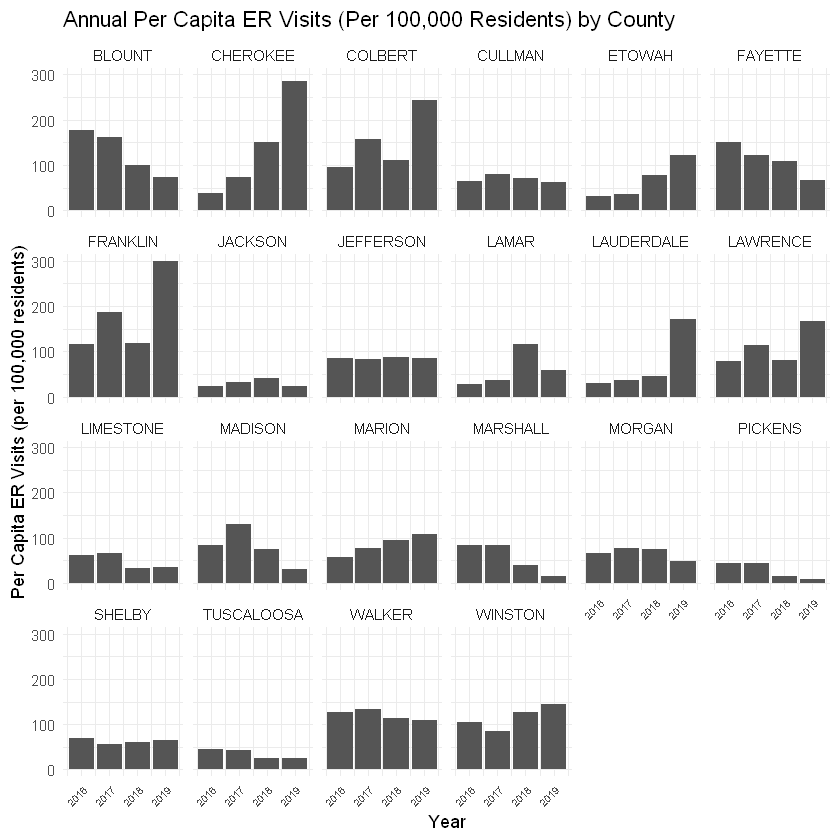

In [19]:
## Per Capita of County by Year
p <-Data_ER_filted %>%
  group_by(year, County) %>%
  summarise(total = 100000 * sum(case_percapita), .groups = "drop") %>%
  ggplot(aes(x = year, y = total, group = County)) +
  geom_col(fill = "#555555") +
  # geom_smooth(method = "lm", se = FALSE, color = "red", linewidth = 0.8) +  # Regression line
  facet_wrap(~ County, ncol = 6) + #, scales = "free_y"
  labs(
    title = "Annual Per Capita ER Visits (Per 100,000 Residents) by County",
    x = "Year", y = "Per Capita ER Visits (per 100,000 residents)"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 6))

# Display in notebook
print(p)

# Save the figure
ggsave("../output/1_summary_year_per.png", plot = p, width = 6.5, height = 4.5, dpi = 300)

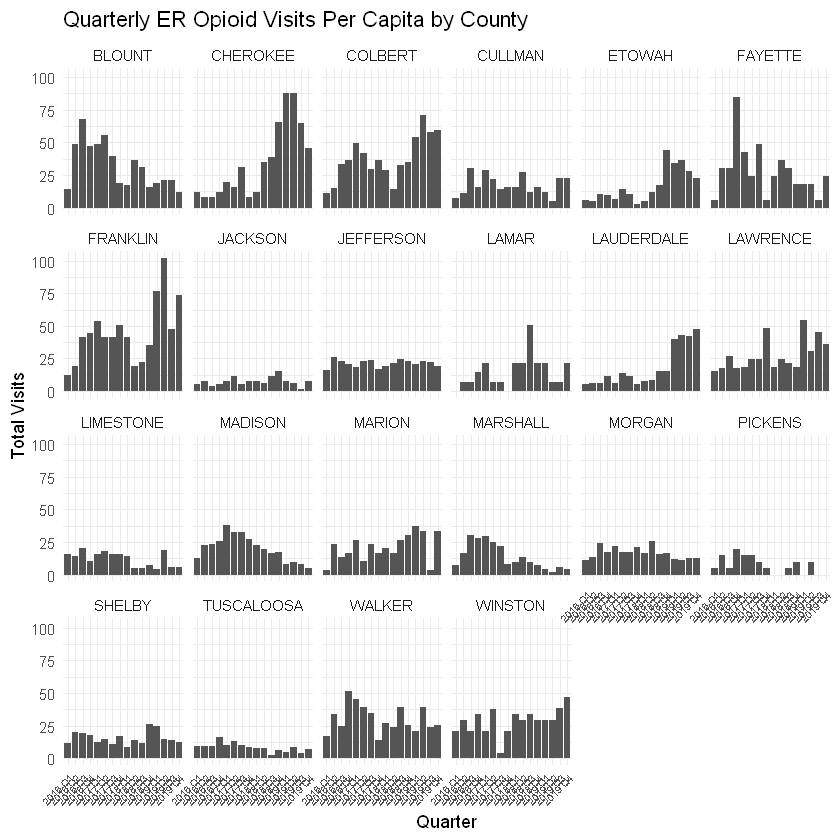

In [10]:
## Summary of County by [Per Capita Quarterly]

# Create year_quarter variable
Data_ER_filted_quarter <- Data_ER_filted %>%
  mutate(
    date = ym(year_month),  # Convert to date
    year = year(date),
    quarter = quarter(date),
    year_quarter = paste0(year, " Q", quarter)
  )

# Group by year_quarter and County
p <- Data_ER_filted_quarter %>%
  group_by(year_quarter, County) %>%
  summarise(total = 100000 * sum(case_percapita), .groups = "drop") %>%
  mutate(year_quarter = factor(year_quarter, levels = unique(year_quarter))) %>%
  ggplot(aes(x = year_quarter, y = total, group = County)) +
  geom_col(fill = "#555555") +
  facet_wrap(~ County, ncol = 6) +
  labs(
    title = "Quarterly ER Opioid Visits Per Capita by County",
    x = "Quarter", y = "Total Visits"
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 6)
  )

# Display plot
print(p)

# Save the figure
ggsave("../output/1_summary_per_quarter.png", plot = p, width = 8, height = 5.5, dpi = 300)

### 2. Descriptive Statistic for Medicine Consumption

In [7]:
# Read Data_ARCOS and clean for next process
Data_ARCOS <- read_csv("../Data/ARCOS_AL_2016_2019_cleaned.csv")

Data_ARCOS_filted <- Data_ARCOS%>%
  filter(drug %in% c("OXYCODONE", "HYDROCODONE", "BUPRENORPHINE", "METHADONE"))%>%
  filter(county %in% toupper(c(
    "Lauderdale", "Limestone", "Madison", "Jackson", "Colbert", "Franklin",
    "Lawrence", "Morgan", "Marshall", "Dekalb", "Marion", "Winston",
    "Cullman", "Blount", "Etowah", "Cherokee", "Lamar", "Fayette",
    "Walker", "Jefferson", "St. Clair", "Pickens", "Tuscaloosa", "Shelby"
  ))
  )%>%
  #mutate(mme = mme/1000000)%>%
  mutate(date = mdy(date))%>%
  rename(County = county)

Data_ARCOS_filted <- Data_ARCOS_filted %>%
  mutate(
    year = as.numeric(format(date, "%Y")),
    month = as.numeric(format(date, "%m")),
    year_month = paste(year,month),
    week = as.numeric(format(date, "%U"))  # Week number of year (starting from 0)
  )

head(Data_ARCOS_filted)

New names:
• `` -> `...1`
Rows: 1048575 Columns: 7
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (3): date, county, drug
dbl (4): ...1, mme, pop, mme_percapita

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,date,County,drug,mme,pop,mme_percapita,year,month,year_month,week
<dbl>,<date>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
393034,2016-01-25,MORGAN,BUPRENORPHINE,37218585,119006,312.74545,2016,1,2016 1,4
394214,2019-04-19,MORGAN,BUPRENORPHINE,1833960,119679,15.32399,2019,4,2019 4,15
394077,2018-12-03,MORGAN,BUPRENORPHINE,1813980,119203,15.21757,2018,12,2018 12,48
394107,2019-01-02,MORGAN,BUPRENORPHINE,1748460,119679,14.60958,2019,1,2019 1,0
394225,2019-04-30,MORGAN,BUPRENORPHINE,1631160,119679,13.62946,2019,4,2019 4,17
394154,2019-02-18,MORGAN,BUPRENORPHINE,1526094,119679,12.75156,2019,2,2019 2,7


In [8]:
# Summary of County
Data_County_ARCOS_summary <- Data_ARCOS_filted %>%
  group_by(year, County, drug) %>%
  summarise(
    mean = mean(mme, na.rm = TRUE),
    total = round(sum(mme/1000000, na.rm = TRUE),2),
      .groups = "drop"
  )%>%
  select(year, County, drug, total) %>%
  pivot_wider(
    names_from = year,
    values_from = total,
    names_prefix = "Total_"
  )%>%
  mutate(
    Total = round(rowSums(select(., starts_with("Total_")), na.rm = TRUE),2)
  )

head(Data_County_ARCOS_summary)

# Save to CSV
#write.csv(Data_County_ARCOS_summary, "../output/Drug_summary.csv", row.names = FALSE)

County,drug,Total_2016,Total_2017,Total_2018,Total_2019,Total
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BLOUNT,BUPRENORPHINE,17.63,19.35,22.93,26.66,86.57
BLOUNT,HYDROCODONE,6.42,5.42,5.29,3.82,20.95
BLOUNT,METHADONE,1.44,1.45,1.35,1.08,5.32
BLOUNT,OXYCODONE,8.97,8.13,8.00,7.23,32.33
CHEROKEE,BUPRENORPHINE,11.76,11.53,16.61,18.06,57.96
CHEROKEE,HYDROCODONE,7.28,6.67,6.36,5.84,26.15


In [9]:
# Summary of Per Capita Drug Consumption by County
Data_County_ARCOS_Annual <- Data_ARCOS_filted %>%
  group_by(year, County, drug) %>%
  summarise(
    mean = mean(mme, na.rm = TRUE),
    total = sum(mme),
    rate = round(mean(mme/pop, na.rm = TRUE), 2), 
      .groups = "drop"
  )%>%
  select(year, County, drug, rate) %>%
  pivot_wider(
    names_from = year,
    values_from = rate,
    names_prefix = "Rate_"
  )%>%
  mutate(
    Avg_Rate = round(rowMeans(select(., starts_with("Rate_")), na.rm = TRUE),2)
  )

head(Data_County_ARCOS_Annual)

County,drug,Rate_2016,Rate_2017,Rate_2018,Rate_2019,Avg_Rate
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BLOUNT,BUPRENORPHINE,0.84,0.92,1.09,1.26,1.03
BLOUNT,HYDROCODONE,0.31,0.26,0.25,0.18,0.25
BLOUNT,METHADONE,0.07,0.07,0.06,0.05,0.06
BLOUNT,OXYCODONE,0.43,0.39,0.38,0.34,0.38
CHEROKEE,BUPRENORPHINE,1.25,1.22,1.75,1.89,1.53
CHEROKEE,HYDROCODONE,0.77,0.71,0.67,0.61,0.69


#### 2.1 Descriptive Table of Buprenorphine

In [102]:
# merge all tables of BUPRENORPHINE

Data_County_ARCOS_Summary_temp <- Data_County_ARCOS_summary%>%
    filter(drug == "BUPRENORPHINE")%>%
    select(-drug)

Data_County_ARCOS_Annual_temp <- Data_County_ARCOS_Annual%>%
    filter(drug == "BUPRENORPHINE")%>%
    select(-drug)

Data_County_pop_sum <- merge(
  County_population_average,
  Data_County_ARCOS_Summary_temp, 
  by = "County"
)

Data_County_pop_sum_rate <- merge(
  Data_County_pop_sum,
  Data_County_ARCOS_Annual_temp, 
  by = "County"
)

Data_County_combined <- Data_County_pop_sum_rate%>%
  select(
    County,
    pop_avg,
    pop_avg,
    Total_2016, Rate_2016,
    Total_2017, Rate_2017,
    Total_2018, Rate_2018,
    Total_2019, Rate_2019,
    Total, Avg_Rate
  )

head(Data_County_combined)

# Save to CSV
write.csv(Data_County_combined, "../output/County_BUPRENORPHINE.csv", row.names = FALSE)

,County,pop_avg,Total_2016,Rate_2016,Total_2017,Rate_2017,Total_2018,Rate_2018,Total_2019,Rate_2019,Total,Avg_Rate
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,BLOUNT,57719.35,17.63,0.84,19.35,0.92,22.93,1.09,26.66,1.26,86.57,1.03
2,CHEROKEE,25945.63,11.76,1.25,11.53,1.22,16.61,1.75,18.06,1.89,57.96,1.53
3,COLBERT,54859.00,42.67,2.14,56.49,2.83,55.73,2.78,69.08,3.43,223.97,2.80
4,CULLMAN,83125.29,55.68,1.84,61.61,2.04,71.18,2.34,79.75,2.61,268.22,2.21
5,ETOWAH,102685.37,123.16,3.27,159.93,4.25,165.87,4.43,179.13,4.80,628.09,4.19
6,FAYETTE,16444.08,1.63,0.27,2.02,0.34,2.58,0.43,4.67,0.79,10.90,0.46


#### 2.2 Descriptive Table of HYDROCODONE

In [103]:
# merge all tables of HYDROCODONE

Data_County_ARCOS_Summary_temp <- Data_County_ARCOS_summary%>%
    filter(drug == "HYDROCODONE")%>%
    select(-drug)

Data_County_ARCOS_Annual_temp <- Data_County_ARCOS_Annual%>%
    filter(drug == "HYDROCODONE")%>%
    select(-drug)

Data_County_pop_sum <- merge(
  County_population_average,
  Data_County_ARCOS_Summary_temp, 
  by = "County"
)

Data_County_pop_sum_rate <- merge(
  Data_County_pop_sum,
  Data_County_ARCOS_Annual_temp, 
  by = "County"
)

Data_County_combined <- Data_County_pop_sum_rate%>%
  select(
    County,
    pop_avg,
    pop_avg,
    Total_2016, Rate_2016,
    Total_2017, Rate_2017,
    Total_2018, Rate_2018,
    Total_2019, Rate_2019,
    Total, Avg_Rate
  )

head(Data_County_combined)

# Save to CSV
write.csv(Data_County_combined, "../output/County_HYDROCODONE.csv", row.names = FALSE)

,County,pop_avg,Total_2016,Rate_2016,Total_2017,Rate_2017,Total_2018,Rate_2018,Total_2019,Rate_2019,Total,Avg_Rate
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,BLOUNT,57719.35,6.42,0.31,5.42,0.26,5.29,0.25,3.82,0.18,20.95,0.25
2,CHEROKEE,25945.63,7.28,0.77,6.67,0.71,6.36,0.67,5.84,0.61,26.15,0.69
3,COLBERT,54859.00,25.48,1.28,23.84,1.19,21.63,1.08,20.04,0.99,90.99,1.14
4,CULLMAN,83125.29,24.40,0.81,21.09,0.70,17.76,0.58,15.03,0.49,78.28,0.64
5,ETOWAH,102685.37,32.42,0.86,28.59,0.76,27.17,0.73,24.78,0.66,112.96,0.75
6,FAYETTE,16444.08,2.64,0.44,2.24,0.37,1.85,0.31,1.70,0.29,8.43,0.35


#### 2.3 Descriptive Table of METHADONE

In [104]:
# merge all tables of METHADONE

Data_County_ARCOS_Summary_temp <- Data_County_ARCOS_summary%>%
    filter(drug == "METHADONE")%>%
    select(-drug)

Data_County_ARCOS_Annual_temp <- Data_County_ARCOS_Annual%>%
    filter(drug == "METHADONE")%>%
    select(-drug)

Data_County_pop_sum <- merge(
  County_population_average,
  Data_County_ARCOS_Summary_temp, 
  by = "County"
)

Data_County_pop_sum_rate <- merge(
  Data_County_pop_sum,
  Data_County_ARCOS_Annual_temp, 
  by = "County"
)

Data_County_combined <- Data_County_pop_sum_rate%>%
  select(
    County,
    pop_avg,
    pop_avg,
    Total_2016, Rate_2016,
    Total_2017, Rate_2017,
    Total_2018, Rate_2018,
    Total_2019, Rate_2019,
    Total, Avg_Rate
  )

head(Data_County_combined)

# Save to CSV
write.csv(Data_County_combined, "../output/County_METHADONE.csv", row.names = FALSE)

,County,pop_avg,Total_2016,Rate_2016,Total_2017,Rate_2017,Total_2018,Rate_2018,Total_2019,Rate_2019,Total,Avg_Rate
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,BLOUNT,57719.35,1.44,0.07,1.45,0.07,1.35,0.06,1.08,0.05,5.32,0.06
2,CHEROKEE,25945.63,2.30,0.24,0.77,0.08,0.78,0.08,0.43,0.05,4.28,0.11
3,COLBERT,54859.00,6.89,0.35,4.86,0.24,4.22,0.21,3.45,0.17,19.42,0.24
4,CULLMAN,83125.29,11.48,0.38,8.04,0.27,5.81,0.19,3.78,0.12,29.11,0.24
5,ETOWAH,102685.37,19.48,0.52,10.42,0.28,8.29,0.22,6.76,0.18,44.95,0.30
6,FAYETTE,16444.08,3.91,0.65,3.53,0.59,2.77,0.46,2.41,0.40,12.62,0.52


#### 2.4 Descriptive Table of OXYCODONE

In [105]:
# merge all tables of OXYCODONE

Data_County_ARCOS_Summary_temp <- Data_County_ARCOS_summary%>%
    filter(drug == "OXYCODONE")%>%
    select(-drug)

Data_County_ARCOS_Annual_temp <- Data_County_ARCOS_Annual%>%
    filter(drug == "OXYCODONE")%>%
    select(-drug)

Data_County_pop_sum <- merge(
  County_population_average,
  Data_County_ARCOS_Summary_temp, 
  by = "County"
)

Data_County_pop_sum_rate <- merge(
  Data_County_pop_sum,
  Data_County_ARCOS_Annual_temp, 
  by = "County"
)

Data_County_combined <- Data_County_pop_sum_rate%>%
  select(
    County,
    pop_avg,
    pop_avg,
    Total_2016, Rate_2016,
    Total_2017, Rate_2017,
    Total_2018, Rate_2018,
    Total_2019, Rate_2019,
    Total, Avg_Rate
  )

head(Data_County_combined)

# Save to CSV
write.csv(Data_County_combined, "../output/County_OXYCODONE.csv", row.names = FALSE)

,County,pop_avg,Total_2016,Rate_2016,Total_2017,Rate_2017,Total_2018,Rate_2018,Total_2019,Rate_2019,Total,Avg_Rate
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,BLOUNT,57719.35,8.97,0.43,8.13,0.39,8.00,0.38,7.23,0.34,32.33,0.38
2,CHEROKEE,25945.63,14.52,1.54,11.99,1.27,11.10,1.17,10.03,1.05,47.64,1.26
3,COLBERT,54859.00,31.91,1.60,25.49,1.28,19.39,0.97,16.66,0.83,93.45,1.17
4,CULLMAN,83125.29,34.24,1.13,30.80,1.02,24.77,0.81,20.75,0.68,110.56,0.91
5,ETOWAH,102685.37,63.52,1.69,49.82,1.33,46.21,1.23,40.96,1.10,200.51,1.34
6,FAYETTE,16444.08,3.96,0.65,3.32,0.55,2.74,0.46,1.95,0.33,11.97,0.50


In [18]:
# Summary of County by Year
Data_County_ARCOS_Annual <- Data_ARCOS_filted %>%
  group_by(County, drug, year) %>%
  summarise(
    mean = mean(mme, na.rm = TRUE),
    total = sum(mme),
    avg_percapita = mean(mme_percapita),
      .groups = "drop"
  )

head(Data_County_ARCOS_Annual)

# Save to CSV
write.csv(Data_County_ARCOS_Annual, "../output/Drug_Annual.csv", row.names = FALSE)

County,drug,year,mean,total,avg_percapita
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
BLOUNT,BUPRENORPHINE,2016,0.04815740,17.625610,0.8376075
BLOUNT,BUPRENORPHINE,2017,0.05302161,19.352887,0.9175352
BLOUNT,BUPRENORPHINE,2018,0.06281466,22.927352,1.0873044
BLOUNT,BUPRENORPHINE,2019,0.07305012,26.663294,1.2632747
BLOUNT,HYDROCODONE,2016,0.01753648,6.418353,0.3050142
BLOUNT,HYDROCODONE,2017,0.01485602,5.422446,0.2570823


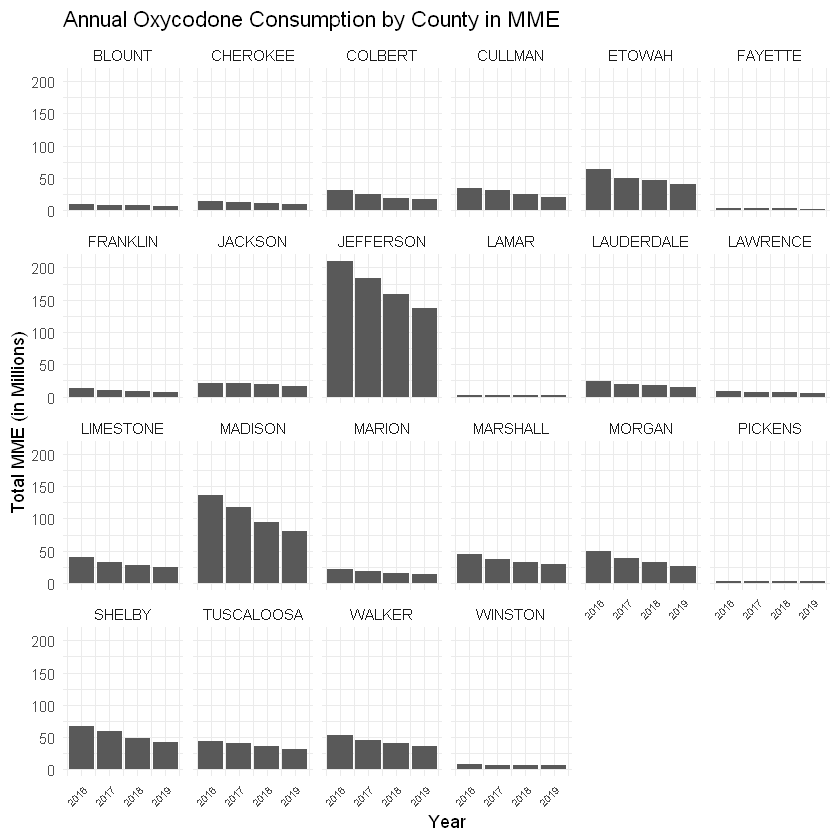

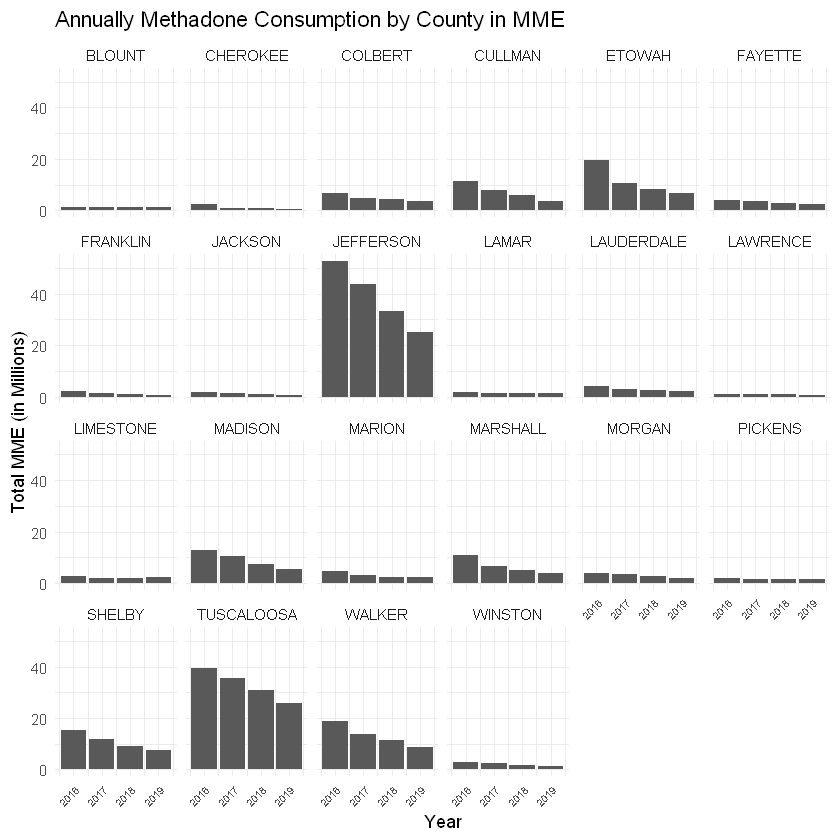

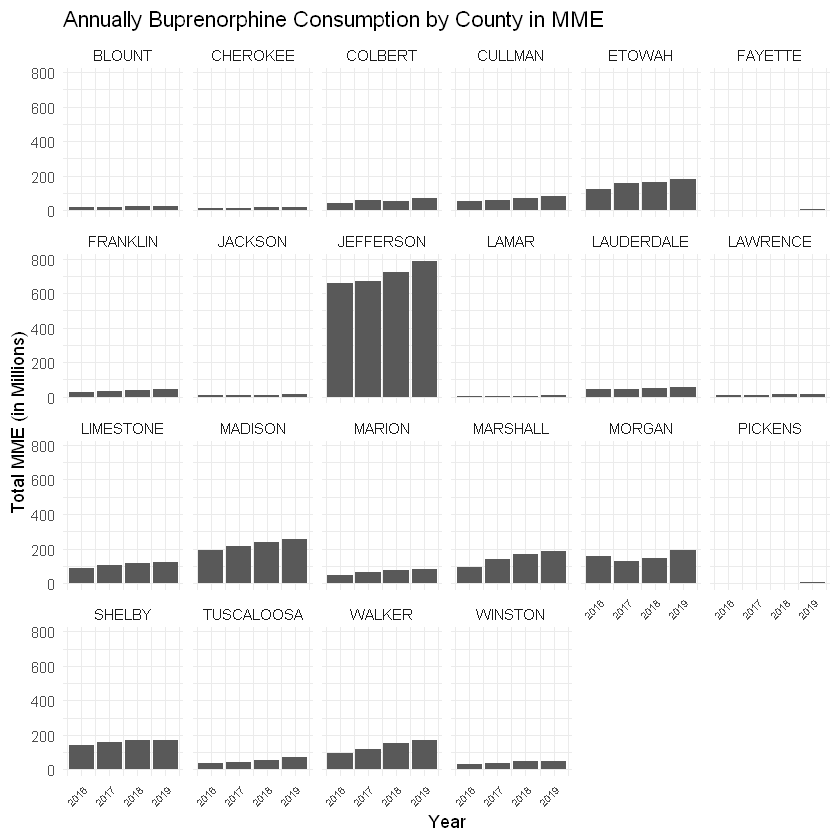

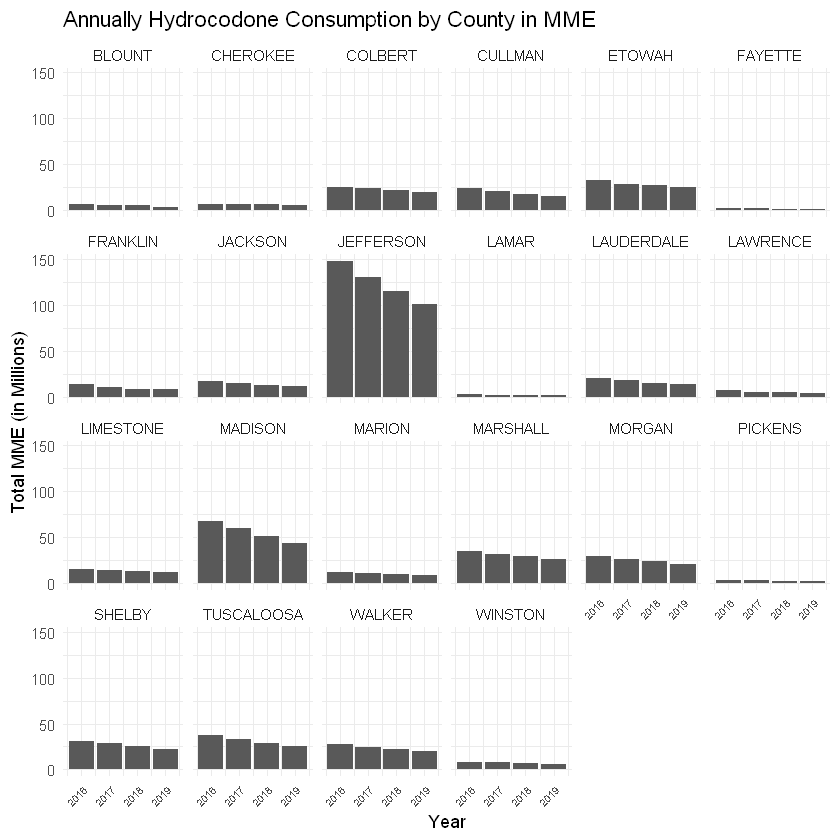

In [15]:
# Trends for All Medicine Consumption [Annually]
p1<-Data_ARCOS_filted %>%
  filter(drug == "OXYCODONE")%>%
  group_by(year, County, drug) %>%
  summarise(total = sum(mme), .groups = "drop") %>%
  ggplot(aes(x = year, y = total)) +
  geom_col(position = "dodge") +
  # geom_smooth(method = "lm", se = FALSE, color = "red", linewidth = 0.8) +  # Regression line
  facet_wrap( ~ County, ncol = 6) + #, scales = "free_y"
  labs(
    title = "Annual Oxycodone Consumption by County in MME",
    x = "Year", y = "Total MME (in Millions)"
  ) +
  theme_minimal() +
  theme(
    legend.position = "top",
    axis.text.x = element_text(angle = 45, hjust = 1, size = 6))


p2<-Data_ARCOS_filted %>%
  filter(drug == "METHADONE")%>%
  group_by(year, County, drug) %>%
  summarise(total = sum(mme), .groups = "drop") %>%
  ggplot(aes(x = year, y = total)) +
  geom_col(position = "dodge") +
  # geom_smooth(method = "lm", se = FALSE, color = "red", linewidth = 0.8) +  # Regression line
  facet_wrap( ~ County, ncol = 6) + #, scales = "free_y"
  labs(
    title = "Annually Methadone Consumption by County in MME",
    x = "Year", y = "Total MME (in Millions)"
  ) +
  theme_minimal() +
  theme(
    legend.position = "top",
    axis.text.x = element_text(angle = 45, hjust = 1, size = 6))


p3<-Data_ARCOS_filted %>%
  filter(drug == "BUPRENORPHINE")%>%
  group_by(year, County, drug) %>%
  summarise(total = sum(mme), .groups = "drop") %>%
  ggplot(aes(x = year, y = total)) +
  geom_col(position = "dodge") +
  # geom_smooth(method = "lm", se = FALSE, color = "red", linewidth = 0.8) +  # Regression line
  facet_wrap( ~ County, ncol = 6) + #, scales = "free_y"
  labs(
    title = "Annually Buprenorphine Consumption by County in MME",
    x = "Year", y = "Total MME (in Millions)"
  ) +
  theme_minimal() +
  theme(
    legend.position = "top",
    axis.text.x = element_text(angle = 45, hjust = 1, size = 6))


p4<-Data_ARCOS_filted %>%
  filter(drug == "HYDROCODONE")%>%
  group_by(year, County, drug) %>%
  summarise(total = sum(mme), .groups = "drop") %>%
  ggplot(aes(x = year, y = total)) +
  geom_col(position = "dodge") +
  # geom_smooth(method = "lm", se = FALSE, color = "red", linewidth = 0.8) +  # Regression line
  facet_wrap( ~ County, ncol = 6) + #, scales = "free_y"
  labs(
    title = "Annually Hydrocodone Consumption by County in MME",
    x = "Year", y = "Total MME (in Millions)"
  ) +
  theme_minimal() +
  theme(
    legend.position = "top",
    axis.text.x = element_text(angle = 45, hjust = 1, size = 6))

p1
p2
p3
p4

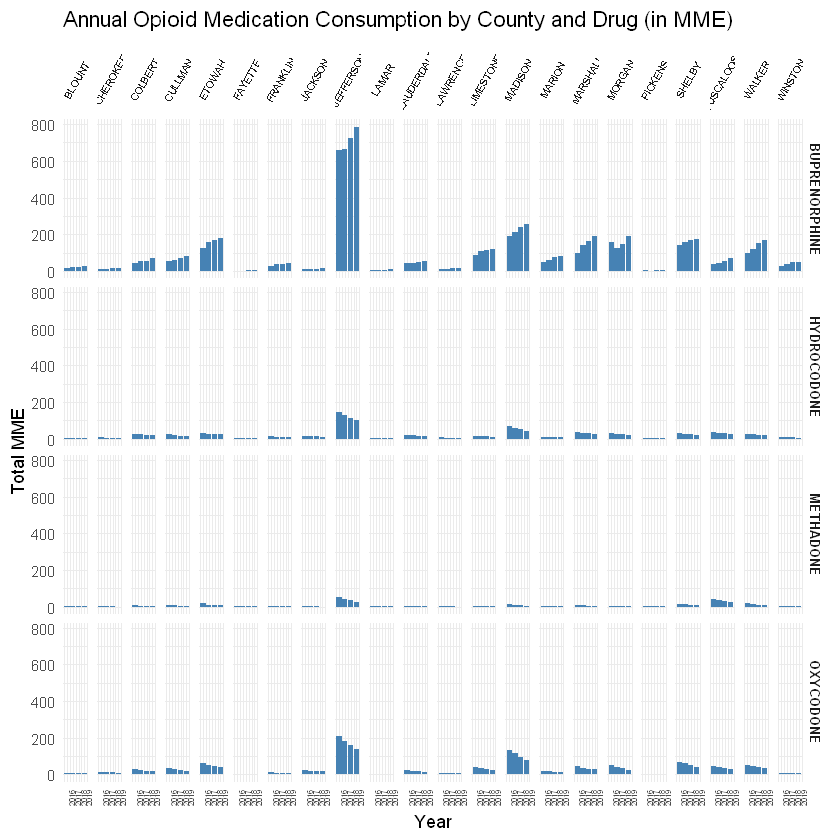

In [16]:
# Trends for All Medicine Consumption [Annually] All in One

p_all <- Data_ARCOS_filted %>%
  filter(drug %in% c("OXYCODONE", "METHADONE", "BUPRENORPHINE", "HYDROCODONE")) %>%
  group_by(year, County, drug) %>%
  summarise(total = sum(mme), .groups = "drop") %>%
  ggplot(aes(x = year, y = total)) +
  geom_col(position = "dodge", fill = "#4682B4") +
facet_grid(drug ~ County) + #, scales = "free_y"
  labs(
    title = "Annual Opioid Medication Consumption by County and Drug (in MME)",
    x = "Year", y = "Total MME"
  ) +
  theme_minimal() +
  theme(
    strip.text.x = element_text(angle = 60,size = 6),
    strip.text.y = element_text(size = 8, face = "bold"),
    axis.text.x = element_text(angle = 90, hjust = 1, size = 5)
  )

p_all

# Save the figure
ggsave("../output/2_medicine_annual.png", plot = p_all, width = 8, height = 6, dpi = 300)


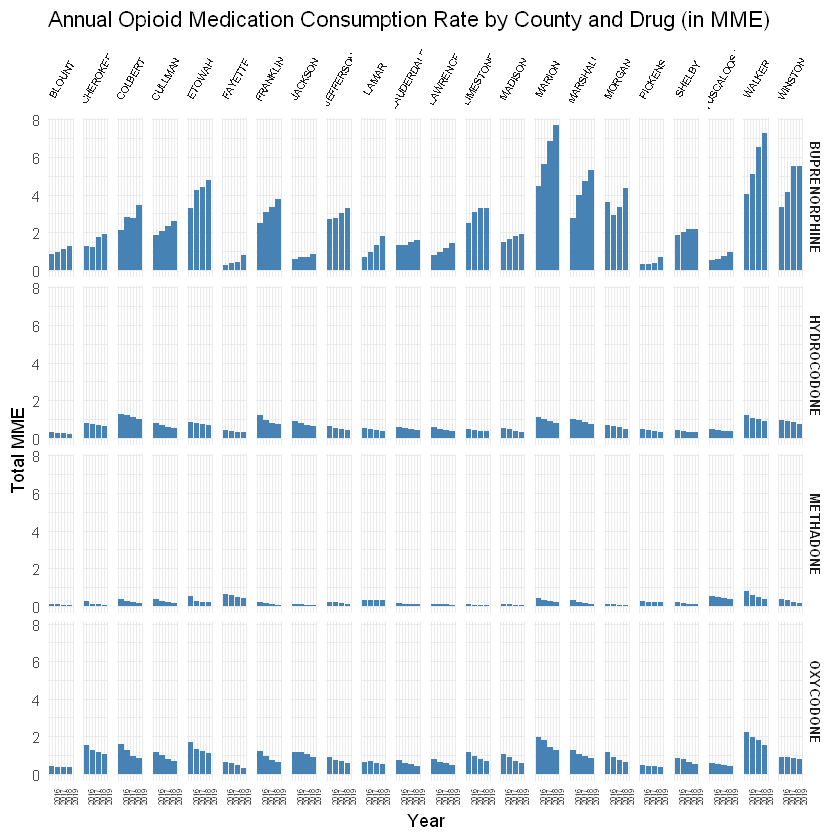

In [29]:
# Trends for All Medicine Consumption Rate [Annually] All in One
p_all <- Data_ARCOS_filted %>%
  filter(drug %in% c("OXYCODONE", "METHADONE", "BUPRENORPHINE", "HYDROCODONE")) %>%
  group_by(year, County, drug) %>%
  summarise(rate = mean(mme_percapita), .groups = "drop") %>%
  ggplot(aes(x = year, y = rate)) +
  geom_col(position = "dodge", fill = "#4682B4") +
facet_grid(drug ~ County) + #, scales = "free_y"
  labs(
    title = "Annual Opioid Medication Consumption Rate by County and Drug (in MME)",
    x = "Year", y = "Total MME"
  ) +
  theme_minimal() +
  theme(
    strip.text.x = element_text(angle = 60,size = 6),
    strip.text.y = element_text(size = 8, face = "bold"),
    axis.text.x = element_text(angle = 90, hjust = 1, size = 5)
  )

p_all

# Save the figure
ggsave("../output/2_medicine_rate_annual.png", plot = p_all, width = 8, height = 6, dpi = 300)


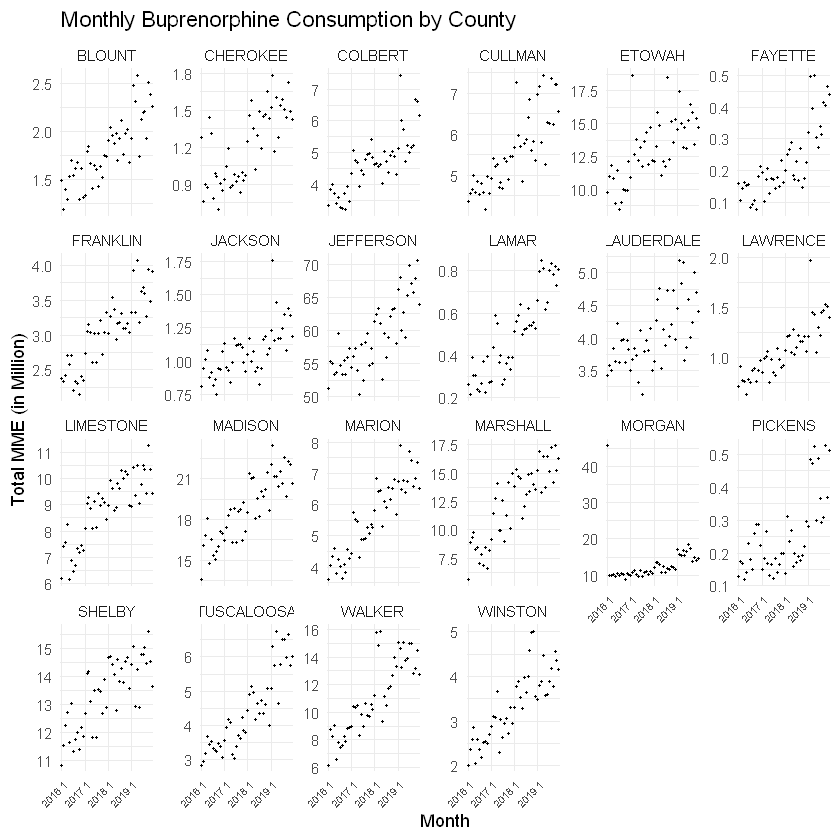

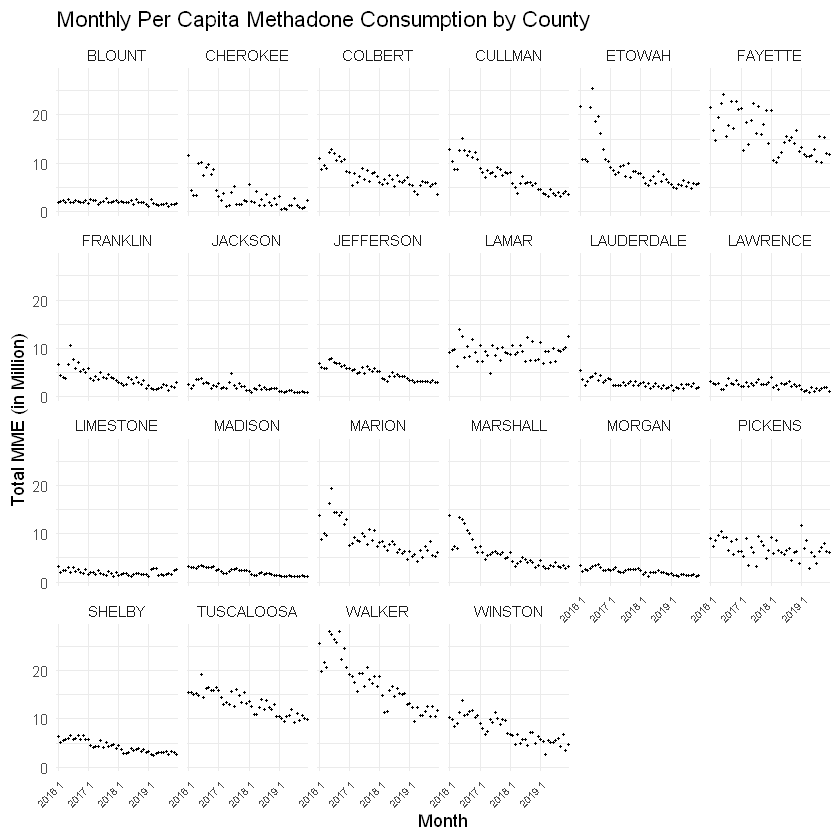

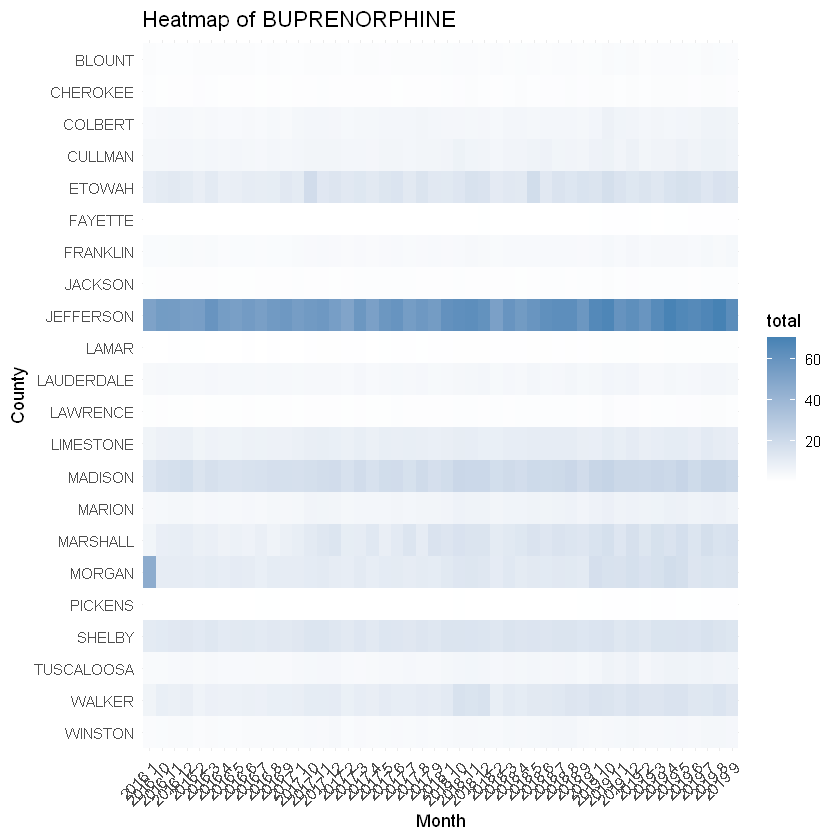

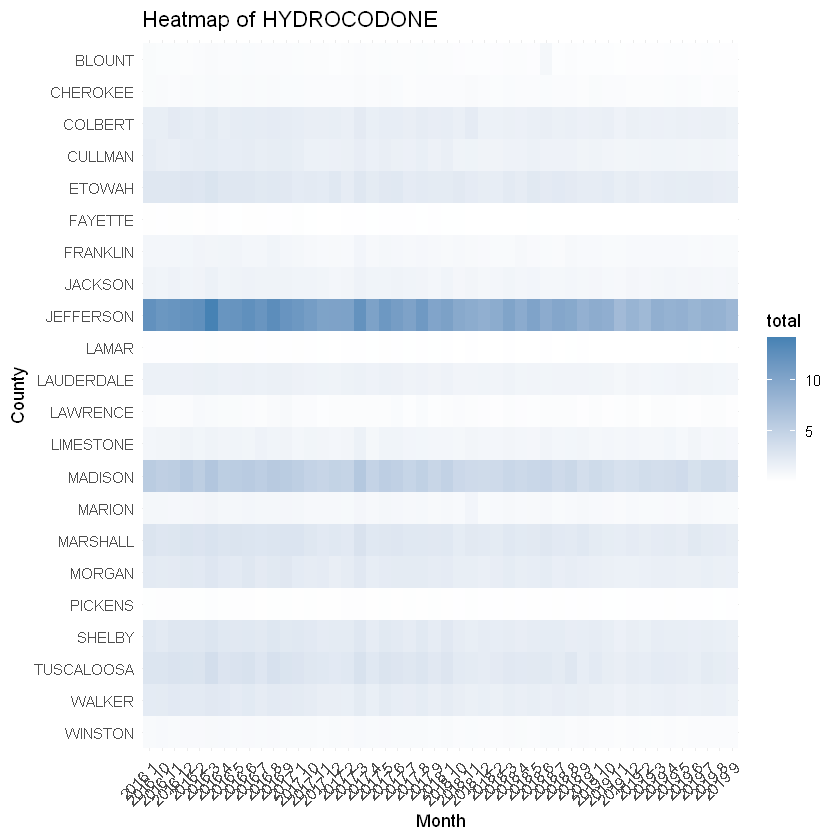

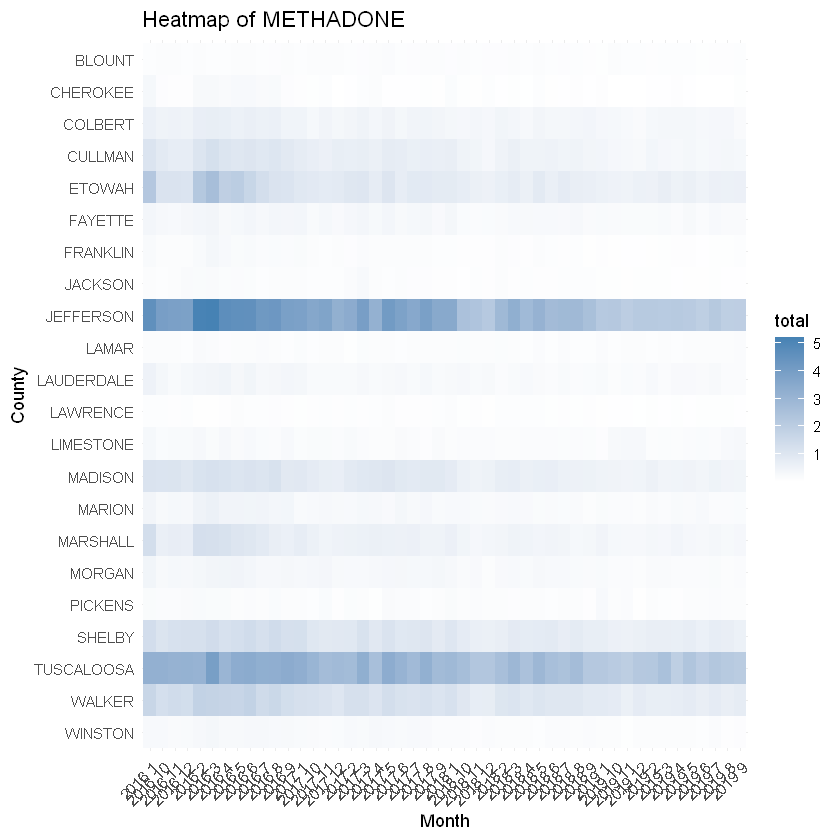

ERROR: Error: 'Data/ARCOS_AL_2016_2019_cleaned.csv' does not exist in current working directory ('C:/Users/julia/OneDrive - The University of Alabama/Research/2025-5-ER-Spatial-Autocorrelation/notebook').


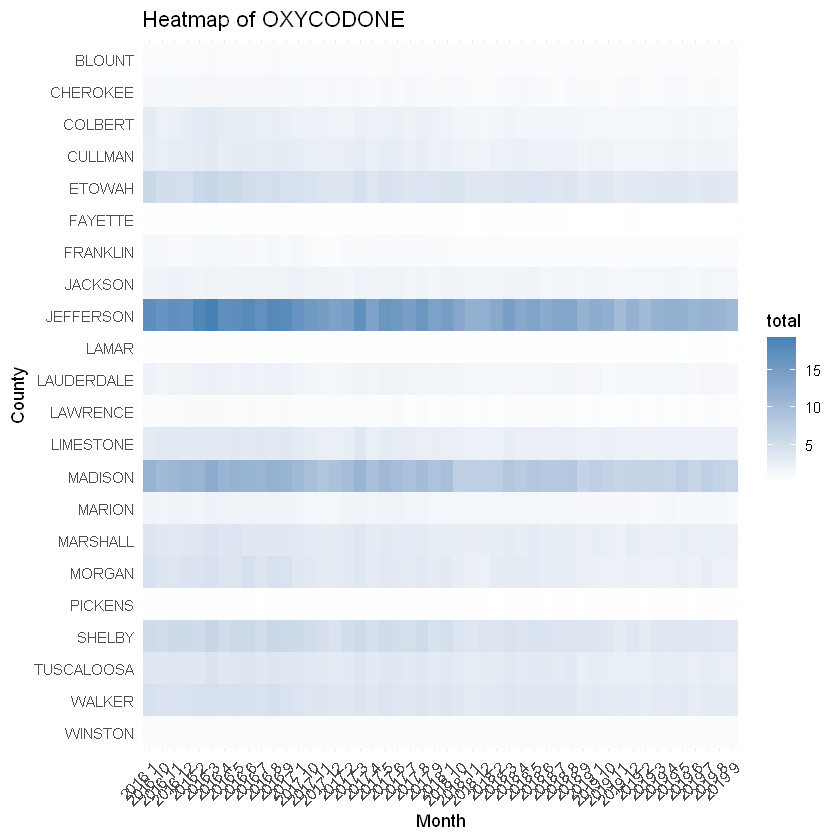

In [30]:
# Summary of County by Month
Data_ARCOS_filted %>%
  filter(drug=="BUPRENORPHINE")%>%
  group_by(year_month, County, drug) %>%
  summarise(total = sum(mme), .groups = "drop") %>%
  ggplot(aes(x = year_month, y = total, group = drug)) +
  # geom_line(aes(color=drug)) +
  # geom_smooth(method = "lm", se = FALSE, color = "red", linewidth = 0.8) +  # Regression line
  geom_point(size = 0.5) +
  # geom_line() +
  scale_x_discrete(
    breaks = function(x) x[seq(1, length(x), by = 12)]
  ) +
  facet_wrap( ~ County, ncol = 6, scales = "free_y") + #
  scale_color_manual(values = colors) +  # Correct scale for lines
  labs(
    title = "Monthly Buprenorphine Consumption by County",
    x = "Month", y = "Total MME (in Million)"
  ) +
  theme_minimal() +
  theme(
    legend.position = "top",
    axis.text.x = element_text(angle = 45, hjust = 1, size = 6))




# Per Capita of County by Month 
Data_ARCOS_filted %>%
  filter(drug=="METHADONE")%>%
  group_by(year_month, County, drug) %>%
  summarise(total = sum(mme_percapita), .groups = "drop") %>%
  ggplot(aes(x = year_month, y = total, group = drug)) +
  # geom_line(aes(color=drug)) +
  # geom_smooth(method = "lm", se = FALSE, color = "red", linewidth = 0.8) +  # Regression line
  geom_point(size = 0.5) +
  # geom_line() +
  scale_x_discrete(
    breaks = function(x) x[seq(1, length(x), by = 12)]
  ) +
  facet_wrap( ~ County, ncol = 6) + #, scales = "free_y"
  scale_color_manual(values = colors) +  # Correct scale for lines
  labs(
    title = "Monthly Per Capita Methadone Consumption by County",
    x = "Month", y = "Total MME (in Million)"
  ) +
  theme_minimal() +
  theme(
    legend.position = "top",
    axis.text.x = element_text(angle = 45, hjust = 1, size = 6))


Data_ARCOS_filted %>%
  filter(drug=="BUPRENORPHINE")%>%
  group_by(year_month, County) %>%
  summarise(total = sum(mme), .groups = "drop") %>%
  ggplot(aes(x = year_month, y = fct_rev(factor(County)), fill = total)) +
  geom_tile() +
  scale_fill_gradient(low = "white", high = "steelblue") +
  labs(title = "Heatmap of BUPRENORPHINE", x = "Month", y = "County") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


Data_ARCOS_filted %>%
  filter(drug=="HYDROCODONE")%>%
  group_by(year_month, County) %>%
  summarise(total = sum(mme), .groups = "drop") %>%
  ggplot(aes(x = year_month, y = fct_rev(factor(County)), fill = total)) +
  geom_tile() +
  scale_fill_gradient(low = "white", high = "steelblue") +
  labs(title = "Heatmap of HYDROCODONE", x = "Month", y = "County") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

Data_ARCOS_filted %>%
  filter(drug=="METHADONE")%>%
  group_by(year_month, County) %>%
  summarise(total = sum(mme), .groups = "drop") %>%
  ggplot(aes(x = year_month, y = fct_rev(factor(County)), fill = total)) +
  geom_tile() +
  scale_fill_gradient(low = "white", high = "steelblue") +
  labs(title = "Heatmap of METHADONE", x = "Month", y = "County") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

Data_ARCOS_filted %>%
  filter(drug=="OXYCODONE")%>%
  group_by(year_month, County) %>%
  summarise(total = sum(mme), .groups = "drop") %>%
  ggplot(aes(x = year_month, y = fct_rev(factor(County)), fill = total)) +
  geom_tile() +
  scale_fill_gradient(low = "white", high = "steelblue") +
  labs(title = "Heatmap of OXYCODONE", x = "Month", y = "County") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
  






## Create Aggrated Data
# Read Data_ARCOS
Data_ARCOS <- read_csv("Data/ARCOS_AL_2016_2019_cleaned.csv")



agg_data_BUPRENORPHINE <- Data_ARCOS %>%
  filter(drug=="BUPRENORPHINE")%>%
  group_by(County) %>%
  summarise(
    total = sum(mme, na.rm = TRUE),
    avg_percapita = mean(mme_percapita, na.rm = TRUE)
  )%>%
  mutate(County = str_to_title(County))%>%
  filter(County %in% c(
    "Lauderdale", "Limestone", "Madison", "Jackson", "Colbert", "Franklin",
    "Lawrence", "Morgan", "Marshall", "Dekalb", "Marion", "Winston",
    "Cullman", "Blount", "Etowah", "Cherokee", "Lamar", "Fayette",
    "Walker", "Jefferson", "St. Clair", "Pickens", "Tuscaloosa", "Shelby"
  ))

agg_data_HYDROCODONE <- Data_ARCOS %>%
  filter(drug=="HYDROCODONE")%>%
  group_by(County) %>%
  summarise(
    total = sum(mme, na.rm = TRUE),
    avg_percapita = mean(mme_percapita, na.rm = TRUE)
  )%>%
  mutate(County = str_to_title(County))%>%
  filter(County %in% c(
    "Lauderdale", "Limestone", "Madison", "Jackson", "Colbert", "Franklin",
    "Lawrence", "Morgan", "Marshall", "Dekalb", "Marion", "Winston",
    "Cullman", "Blount", "Etowah", "Cherokee", "Lamar", "Fayette",
    "Walker", "Jefferson", "St. Clair", "Pickens", "Tuscaloosa", "Shelby"
  ))



agg_data_OXYCODONE <- Data_ARCOS %>%
  filter(drug=="OXYCODONE")%>%
  group_by(County) %>%
  summarise(
    total = sum(mme, na.rm = TRUE),
    avg_percapita = mean(mme_percapita, na.rm = TRUE)
  )%>%
  mutate(County = str_to_title(County))%>%
  filter(County %in% c(
    "Lauderdale", "Limestone", "Madison", "Jackson", "Colbert", "Franklin",
    "Lawrence", "Morgan", "Marshall", "Dekalb", "Marion", "Winston",
    "Cullman", "Blount", "Etowah", "Cherokee", "Lamar", "Fayette",
    "Walker", "Jefferson", "St. Clair", "Pickens", "Tuscaloosa", "Shelby"
  ))



agg_data_METHADONE <- Data_ARCOS %>%
  filter(drug=="METHADONE")%>%
  group_by(County) %>%
  summarise(
    total = sum(mme, na.rm = TRUE),
    avg_percapita = mean(mme_percapita, na.rm = TRUE)
  )%>%
  mutate(County = str_to_title(County))%>%
  filter(County %in% c(
    "Lauderdale", "Limestone", "Madison", "Jackson", "Colbert", "Franklin",
    "Lawrence", "Morgan", "Marshall", "Dekalb", "Marion", "Winston",
    "Cullman", "Blount", "Etowah", "Cherokee", "Lamar", "Fayette",
    "Walker", "Jefferson", "St. Clair", "Pickens", "Tuscaloosa", "Shelby"
  ))






write.csv(agg_data_BUPRENORPHINE, "Data/agg_data_BUPRENORPHINE.csv")
write.csv(agg_data_HYDROCODONE, "Data/agg_data_HYDROCODONE.csv")
write.csv(agg_data_OXYCODONE, "Data/agg_data_OXYCODONE.csv")
write.csv(agg_data_METHADONE, "Data/agg_data_METHADONE.csv")



#Year-on-year Month-on-month

### 3. Spatiotemporal Analysis

In [ ]:
# Get Geographic information
#invisible(install.packages("tigris"))
invisible(library(tigris))

# Prepare for repr system to render spatial (sf) objects in rich formats (like maps) inside Jupyter Notebooks
#invisible(install.packages("geojsonio"))
invisible(library(geojsonio))


# Prepare sdmTMB package and sf files reading
#invisible(install.packages("sdmTMB"))
invisible(library(sdmTMB))
invisible(library(sf))

In [8]:
head(al_counties_filted)

ERROR: Error: object 'al_counties_filted' not found


In [9]:
# Read AL counties's geographic information from tigris package
al_counties <- counties(state = "AL", cb = TRUE, class = "sf")


# Mutate County variable
al_counties$County <- toupper(al_counties$NAME) 

# Filter Counties located at northwest of AL
al_counties_filted <- al_counties%>%
  filter(County %in% toupper(c(
    "Lauderdale", "Limestone", "Madison", "Jackson", "Colbert", "Franklin",
    "Lawrence", "Morgan", "Marshall", "Dekalb", "Marion", "Winston",
    "Cullman", "Blount", "Etowah", "Cherokee", "Lamar", "Fayette",
    "Walker", "Jefferson", "St. Clair", "Pickens", "Tuscaloosa", "Shelby"
  ))
  )


Retrieving data for the year 2024



ERROR: Error in data.matrix(data): 'list' object cannot be coerced to type 'double'


In [32]:
# Join ER data and GIS on County
ER_GIS <- left_join(Data_ER_filted,al_counties_filted, by = c("County"))

#write.csv(ER_GIS, "../Data/ER_GIS.csv")

# Convert dataset to sf structure
ER_GIS_sf <- st_as_sf(ER_GIS)

Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sf

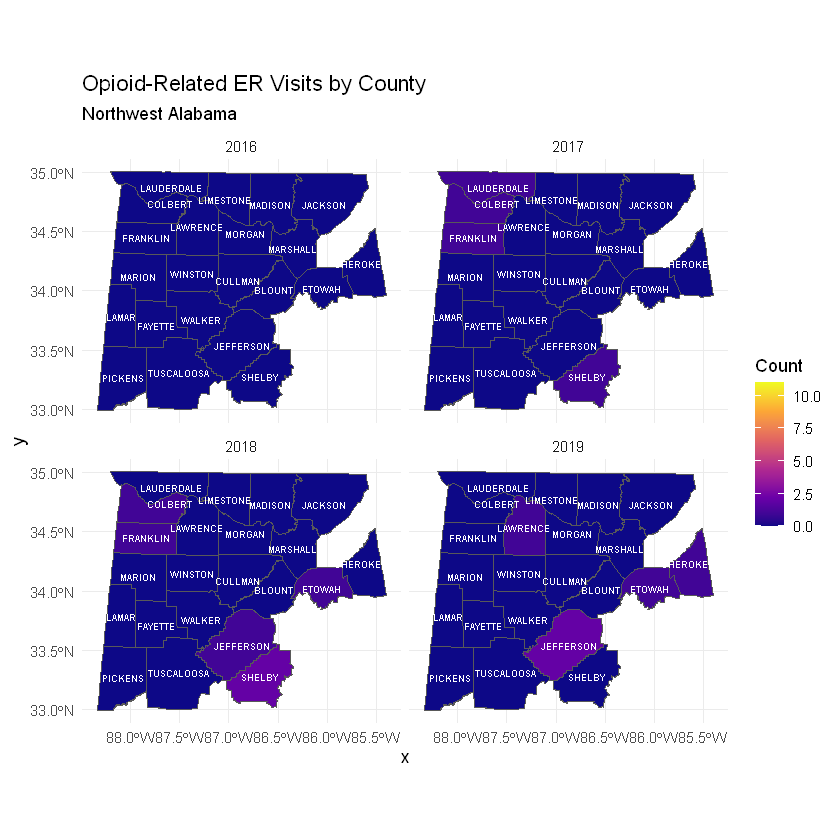

In [13]:
# Plot Spatiotemporal for ER Visits
p <- ggplot(data = ER_GIS) +
  geom_sf(aes(fill = Count)) +
  facet_wrap(~ year) +
  scale_fill_viridis_c(option = "plasma") + #"cividis" "viridis"
  labs(
    title = "Opioid-Related ER Visits by County",
    subtitle = "Northwest Alabama"
  ) +
  geom_sf_text(aes(label = County), size = 2, color = "white", fontface = "bold") +
  theme_minimal()


# Display in notebook
print(p)

# Save the figure
ggsave("../output/3_ER_spatiotemporal.png", plot = p, width = 9, height = 6, dpi = 300)

Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"


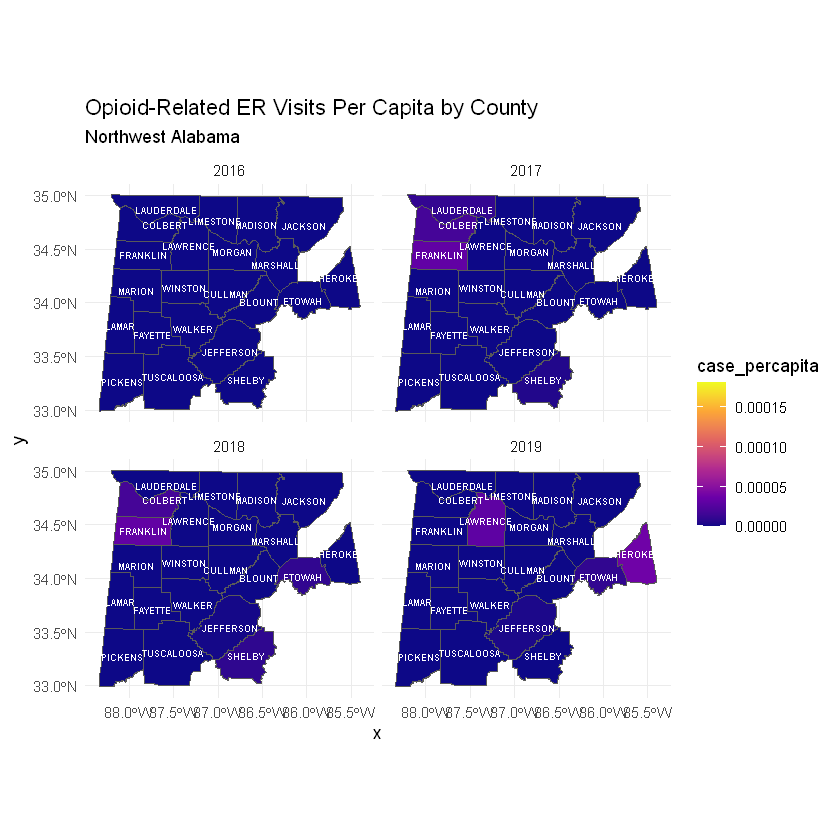

In [64]:
# Plot Spatiotemporal for ER Per Capita Visits
p <- ggplot(data = ER_GIS) +
  geom_sf(aes(fill = case_percapita)) +
  facet_wrap(~ year) +
  scale_fill_viridis_c(option = "plasma") + #"cividis" "viridis"
  labs(
    title = "Opioid-Related ER Visits Per Capita by County",
    subtitle = "Northwest Alabama"
  ) +
  geom_sf_text(aes(label = County), size = 2, color = "white", fontface = "bold") +
  theme_minimal()


# Display in notebook
print(p)

# Save the figure
ggsave("../output/3_ER_per_spatiotemporal.png", plot = p, width = 9, height = 6, dpi = 300)

In [71]:
Data_BUPRENORPHINE <- Data_ARCOS_filted %>%
    filter(drug == "BUPRENORPHINE")

BUPRENORPHINE_GIS <- left_join(Data_BUPRENORPHINE, al_counties_filted, by = c("County"))

write.csv(BUPRENORPHINE_GIS, "../Data/BUPRENORPHINE_GIS.csv")

# Convert dataset to sf structure
BUPRENORPHINE_GIS <- st_as_sf(BUPRENORPHINE_GIS)

Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sf

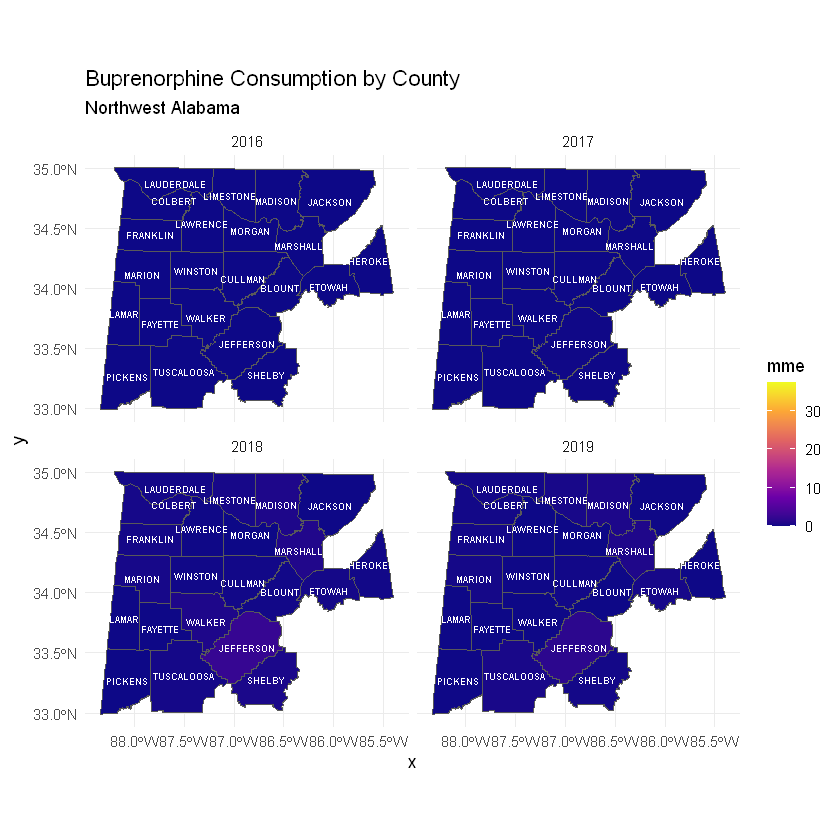

In [73]:
# Plot Spatiotemporal for Medication Visits
p <- ggplot(data = BUPRENORPHINE_GIS) +
  geom_sf(aes(fill = mme)) +
  facet_wrap(~ year) +
  scale_fill_viridis_c(option = "plasma") + #"cividis" "viridis"
  labs(
    title = "Buprenorphine Consumption by County",
    subtitle = "Northwest Alabama"
  ) +
  geom_sf_text(aes(label = County), size = 2, color = "white", fontface = "bold") +
  theme_minimal()


# Display in notebook
print(p)

# Save the figure
ggsave("../output/3_Buprenorphine_spatiotemporal.png", plot = p, width = 9, height = 6, dpi = 300)

Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sf

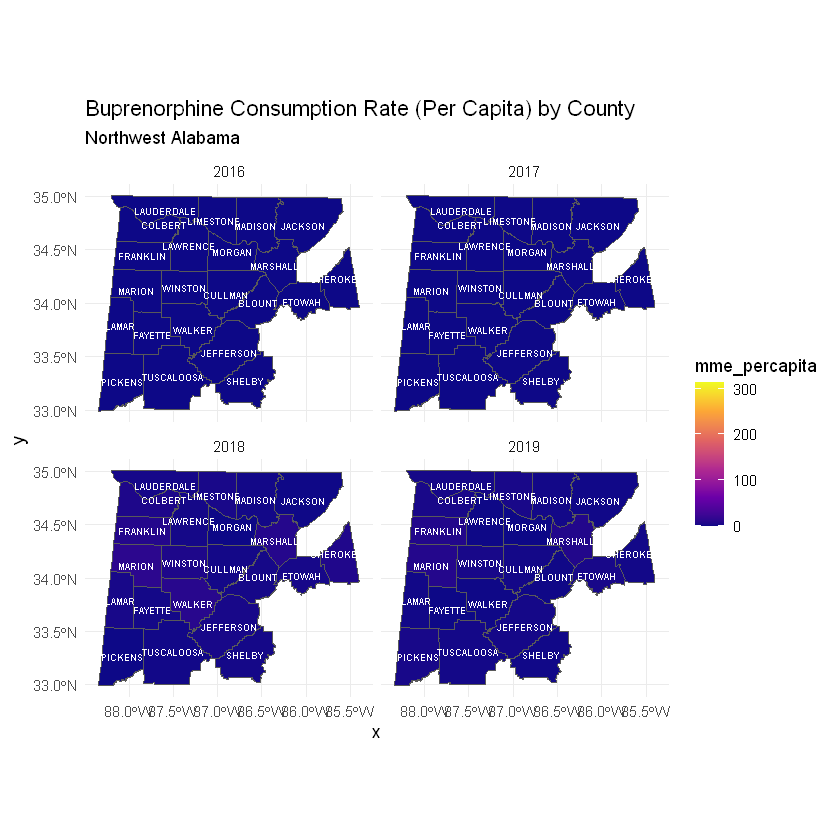

In [82]:
# Plot Spatiotemporal for Medication Consumption (Rate)
p <- ggplot(data = BUPRENORPHINE_GIS) +
  geom_sf(aes(fill = mme_percapita)) +
  facet_wrap(~ year) +
  scale_fill_viridis_c(option = "plasma") + #"cividis" "viridis"
  labs(
    title = "Buprenorphine Consumption Rate (Per Capita) by County",
    subtitle = "Northwest Alabama"
  ) +
  geom_sf_text(aes(label = County), size = 2, color = "white", fontface = "bold") +
  theme_minimal()


# Display in notebook
print(p)

# Save the figure
ggsave("../output/3_Buprenorphine_rate_spatiotemporal.png", plot = p, width = 9, height = 6, dpi = 300)

In [74]:
Data_HYDROCODONE <- Data_ARCOS_filted %>%
    filter(drug == "HYDROCODONE")

HYDROCODONE_GIS <- left_join(Data_HYDROCODONE, al_counties_filted, by = c("County"))

write.csv(HYDROCODONE_GIS, "../Data/HYDROCODONE_GIS.csv")

# Convert dataset to sf structure
HYDROCODONE_GIS <- st_as_sf(HYDROCODONE_GIS)

Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sf

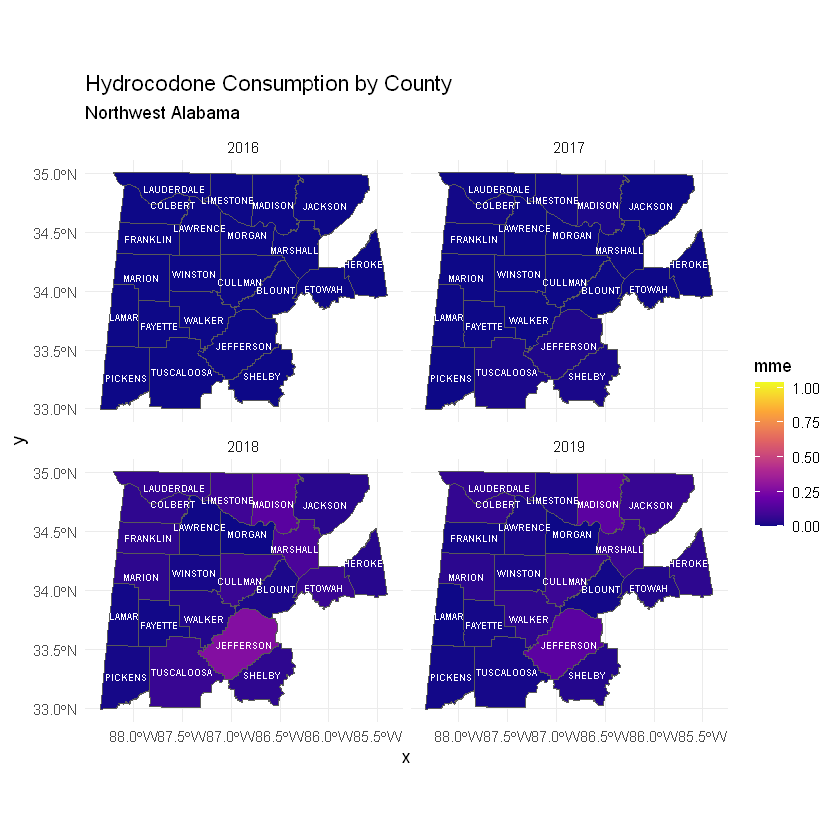

In [76]:
# Plot Spatiotemporal for Medication Visits
p <- ggplot(data = HYDROCODONE_GIS) +
  geom_sf(aes(fill = mme)) +
  facet_wrap(~ year) +
  scale_fill_viridis_c(option = "plasma") + #"cividis" "viridis"
  labs(
    title = "Hydrocodone Consumption by County",
    subtitle = "Northwest Alabama"
  ) +
  geom_sf_text(aes(label = County), size = 2, color = "white", fontface = "bold") +
  theme_minimal()


# Display in notebook
print(p)

# Save the figure
ggsave("../output/3_Hydrocodone_spatiotemporal.png", plot = p, width = 9, height = 6, dpi = 300)

Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sf

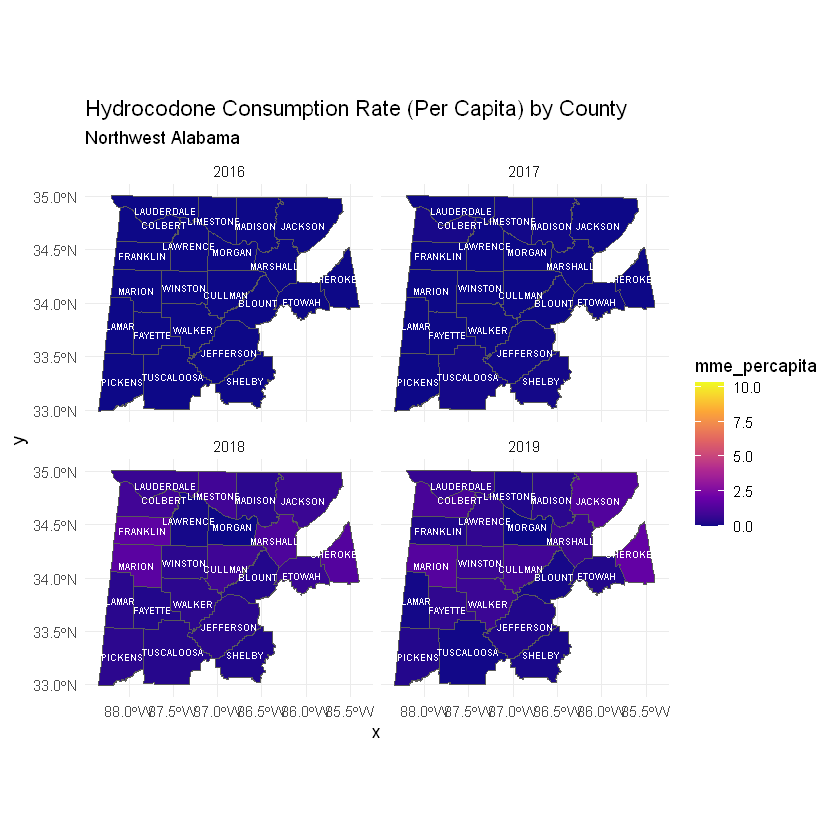

In [83]:
# Plot Spatiotemporal for HYDROCODONE consumption
p <- ggplot(data = HYDROCODONE_GIS) +
  geom_sf(aes(fill = mme_percapita)) +
  facet_wrap(~ year) +
  scale_fill_viridis_c(option = "plasma") + #"cividis" "viridis"
  labs(
    title = "Hydrocodone Consumption Rate (Per Capita) by County",
    subtitle = "Northwest Alabama"
  ) +
  geom_sf_text(aes(label = County), size = 2, color = "white", fontface = "bold") +
  theme_minimal()


# Display in notebook
print(p)

# Save the figure
ggsave("../output/3_Hydrocodone_rate_spatiotemporal.png", plot = p, width = 9, height = 6, dpi = 300)

In [77]:
Data_METHADONE <- Data_ARCOS_filted %>%
    filter(drug == "METHADONE")

METHADONE_GIS <- left_join(Data_METHADONE, al_counties_filted, by = c("County"))

write.csv(METHADONE_GIS, "../Data/METHADONE_GIS.csv")

# Convert dataset to sf structure
METHADONE_GIS <- st_as_sf(METHADONE_GIS)

Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sf

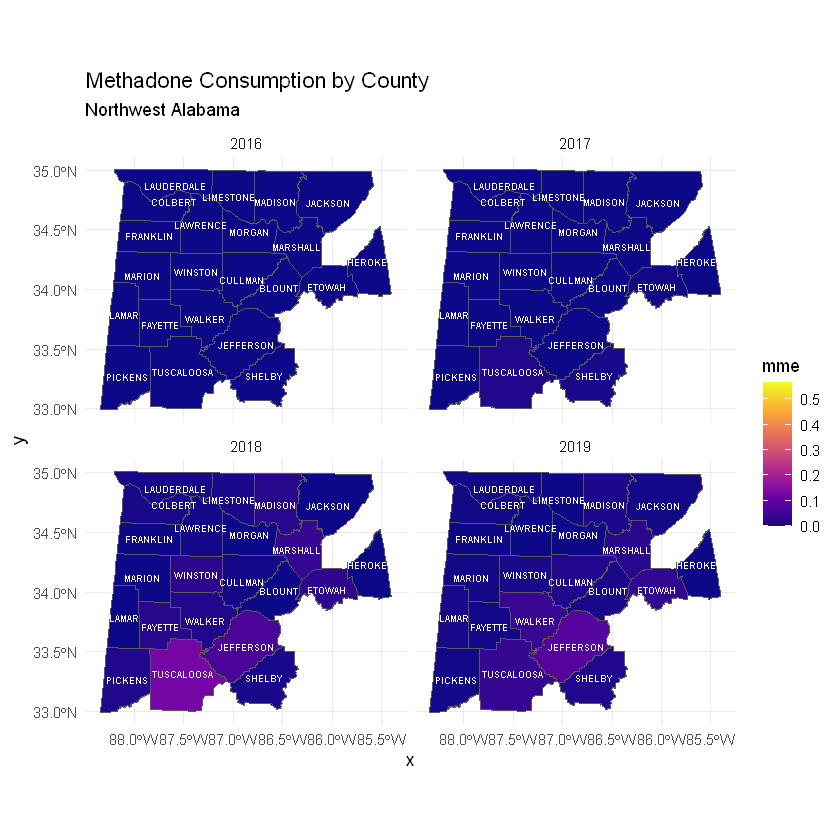

In [78]:
# Plot Spatiotemporal for Medication Visits
p <- ggplot(data = METHADONE_GIS) +
  geom_sf(aes(fill = mme)) +
  facet_wrap(~ year) +
  scale_fill_viridis_c(option = "plasma") + #"cividis" "viridis"
  labs(
    title = "Methadone Consumption by County",
    subtitle = "Northwest Alabama"
  ) +
  geom_sf_text(aes(label = County), size = 2, color = "white", fontface = "bold") +
  theme_minimal()


# Display in notebook
print(p)

# Save the figure
ggsave("../output/3_Methadone_spatiotemporal.png", plot = p, width = 9, height = 6, dpi = 300)

Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sf

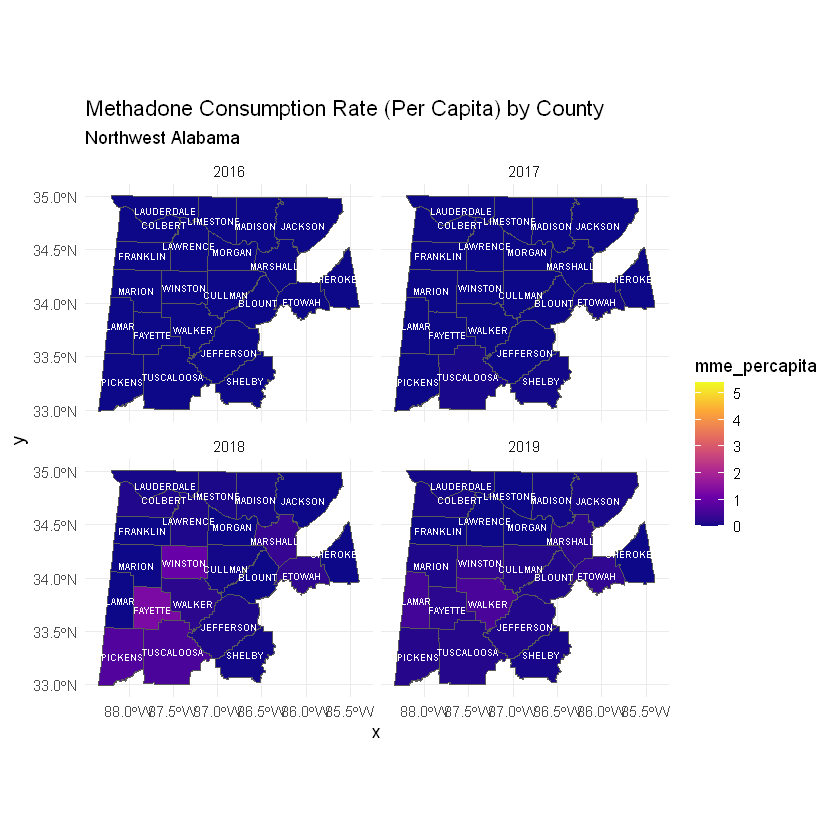

In [84]:
# Plot Spatiotemporal for METHADONE consumption
p <- ggplot(data = METHADONE_GIS) +
  geom_sf(aes(fill = mme_percapita)) +
  facet_wrap(~ year) +
  scale_fill_viridis_c(option = "plasma") + #"cividis" "viridis"
  labs(
    title = "Methadone Consumption Rate (Per Capita) by County",
    subtitle = "Northwest Alabama"
  ) +
  geom_sf_text(aes(label = County), size = 2, color = "white", fontface = "bold") +
  theme_minimal()


# Display in notebook
print(p)

# Save the figure
ggsave("../output/3_Methadone_rate_spatiotemporal.png", plot = p, width = 9, height = 6, dpi = 300)

In [79]:
Data_OXYCODONE <- Data_ARCOS_filted %>%
    filter(drug == "OXYCODONE")

OXYCODONE_GIS <- left_join(Data_OXYCODONE, al_counties_filted, by = c("County"))

write.csv(OXYCODONE_GIS, "../Data/OXYCODONE_GIS.csv")

# Convert dataset to sf structure
OXYCODONE_GIS <- st_as_sf(OXYCODONE_GIS)

Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sf

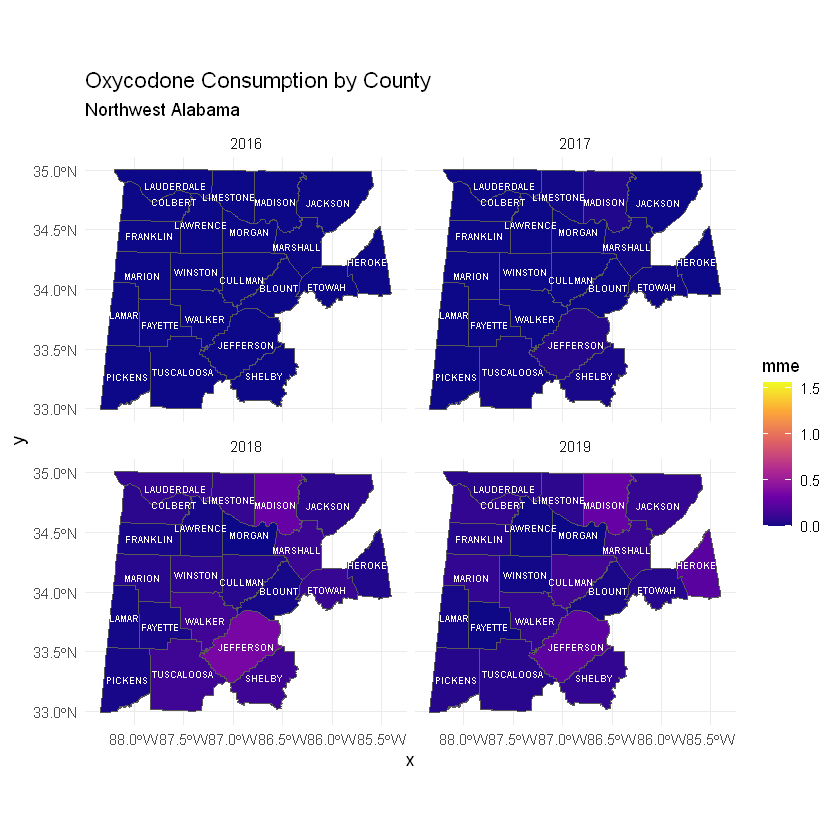

In [80]:
# Plot Spatiotemporal for Medication Visits
p <- ggplot(data = OXYCODONE_GIS) +
  geom_sf(aes(fill = mme)) +
  facet_wrap(~ year) +
  scale_fill_viridis_c(option = "plasma") + #"cividis" "viridis"
  labs(
    title = "Oxycodone Consumption by County",
    subtitle = "Northwest Alabama"
  ) +
  geom_sf_text(aes(label = County), size = 2, color = "white", fontface = "bold") +
  theme_minimal()


# Display in notebook
print(p)

# Save the figure
ggsave("../output/3_Oxycodone_spatiotemporal.png", plot = p, width = 9, height = 6, dpi = 300)

Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
"st_point_on_surface may not give correct results for longitude/latitude data"
Warning message in st_point_on_surface.sf

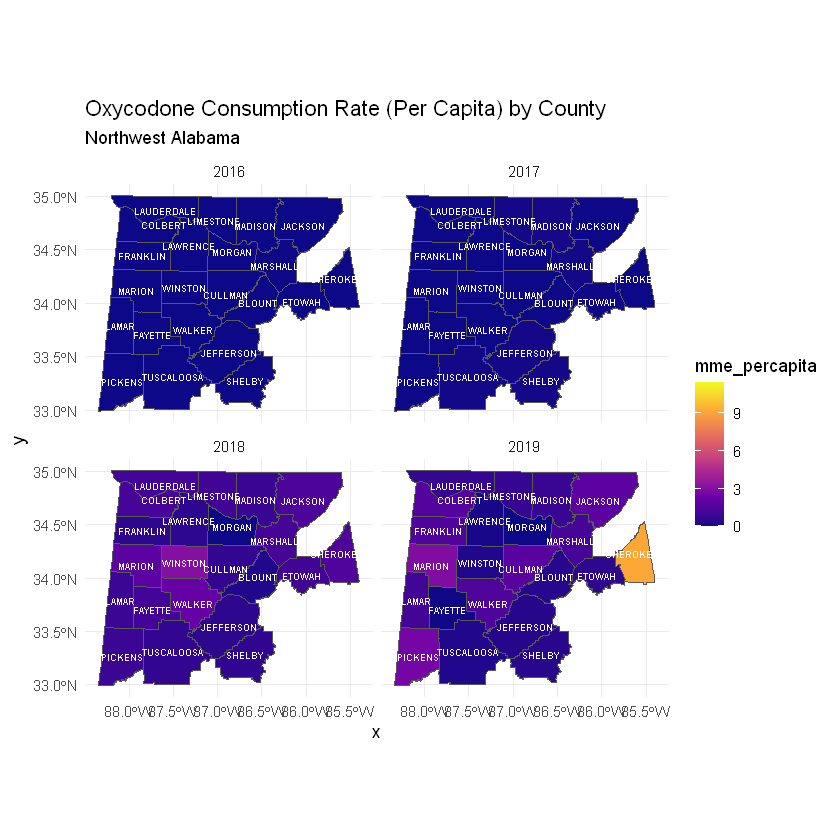

In [85]:
# Plot Spatiotemporal for OXYCODONE consumption
p <- ggplot(data = OXYCODONE_GIS) +
  geom_sf(aes(fill = mme_percapita)) +
  facet_wrap(~ year) +
  scale_fill_viridis_c(option = "plasma") + #"cividis" "viridis"
  labs(
    title = "Oxycodone Consumption Rate (Per Capita) by County",
    subtitle = "Northwest Alabama"
  ) +
  geom_sf_text(aes(label = County), size = 2, color = "white", fontface = "bold") +
  theme_minimal()


# Display in notebook
print(p)

# Save the figure
ggsave("../output/3_Oxycodone_rate_spatiotemporal.png", plot = p, width = 9, height = 6, dpi = 300)

In [31]:
head(ER_GIS)

...1 Date       County   Count pop    case_percapita year month year_month
1  9   2016-01-01 BLOUNT   0      57494 0              2016 1     2016 1    
2 19   2016-01-01 CHEROKEE 0      25768 0              2016 1     2016 1    
3 33   2016-01-01 COLBERT  0      54497 0              2016 1     2016 1    
4 43   2016-01-01 CULLMAN  0      82450 0              2016 1     2016 1    
5 55   2016-01-01 ETOWAH   0     102855 0              2016 1     2016 1    
6 57   2016-01-01 FAYETTE  0      16563 0              2016 1     2016 1    
  week geometry                       ⋯ GEOIDFQ        GEOID NAME    
1 0    MULTIPOLYGON (((-86.96336 3... ⋯ 0500000US01009 01009 Blount  
2 0    MULTIPOLYGON (((-85.84384 3... ⋯ 0500000US01019 01019 Cherokee
3 0    MULTIPOLYGON (((-88.13925 3... ⋯ 0500000US01033 01033 Colbert 
4 0    MULTIPOLYGON (((-87.15104 3... ⋯ 0500000US01043 01043 Cullman 
5 0    MULTIPOLYGON (((-86.36962 3... ⋯ 0500000US01055 01055 Etowah  
6 0    MULTIPOLYGON (((-87.95179 3... ⋯ 0500000US01057 01057 Fayette 
  NAMELSAD        STUSPS STATE_NAME LSAD ALAND      AWATER   
1 Blount County   AL     Alabama    06   1670259099  14860281
2 Cherokee County AL     Alabama    06   1433614765 120316891
3 Colbert County  AL     Alabama    06   1535740663  79162005
4 Cullman County  AL     Alabama    06   1902985237  52510688
5 Etowah County   AL     Alabama    06   1386015447  34924289
6 Fayette County  AL     Alabama    06   1625693253   4330881
  geometry                      
1 MULTIPOLYGON (((-86.96336 3...
2 MULTIPOLYGON (((-85.84384 3...
3 MULTIPOLYGON (((-88.13925 3...
4 MULTIPOLYGON (((-87.15104 3...
5 MULTIPOLYGON (((-86.36962 3...
6 MULTIPOLYGON (((-87.95179 3...

In [3]:
head(ER_GIS_sf)

ERROR: Error: object 'ER_GIS_sf' not found


In [2]:
#ER_GIS

st_geometry(ER_GIS_sf) <- "geometry"      # set the correct geometry column
ER_GIS_sf <- ER_GIS_sf[, !duplicated(names(ER_GIS_sf))]  # drop duplicates if needed




ERROR: Error: object 'ER_GIS_sf' not found


In [ ]:

er_year <- ER_GIS_sf %>%
  # Group data by County and year
  group_by(County, year) %>%
  # Summarize data for each county-year combination
  summarise(
    Count = sum(Count, na.rm = TRUE),     # Sum the Count variable, ignoring NA values
    pop   = mean(pop, na.rm = TRUE),      # Calculate mean population, ignoring NA values
    geometry = st_union(geometry),        # Merge geometries to keep one polygon per county
    .groups = "drop"                      # Drop grouping structure after summarizing
  )


# Safe interior point per county in projected CRS
centers <- st_point_on_surface(er_year)
coords  <- st_coordinates(centers)
er_year$X <- coords[,1]
er_year$Y <- coords[,2]

# Build the mesh
mesh <- make_mesh(er_year, xy_cols = c("X","Y"), cutoff = 30000)  # try 30 km; adjust if too coarse/fine



In [ ]:
fit <- sdmTMB(
  formula = Count ~ year + (1|County),
  data = ER_GIS,
  time = "year",        # Time variable
  mesh = mesh,          # Spatial mesh
  family = poisson(),
  spatial = "on",       # Include spatial random effect
  spatiotemporal = "ar1" # Temporal correlation across years
)

In [16]:
data <- st_set_geometry(droplevels(st_drop_geometry(data)), st_geometry(data))

ERROR: Error in UseMethod("st_geometry"): no applicable method for 'st_geometry' applied to an object of class "function"
